## **Elaborazione di Immagini Mediche**
### 2021/22 - VESSELWALL SEGMENTATION CHALLENGE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0 
!pip install plotly==5.3.1
!pip install pydicom

# Import

In [3]:
import os
import random
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import segmentation_models as sm
import plotly.express as px
import math

import pydicom
import glob

from datetime import datetime
from tqdm import tqdm

from matplotlib import pyplot as plt

from scipy import ndimage
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

import skimage
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
from skimage import morphology
from skimage import filters
from skimage import color,exposure
from skimage import measure

from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical, normalize
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.metrics import MeanIoU

import cv2

import re

from segmentation_models import Unet
from segmentation_models.metrics import FScore, IOUScore

from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Functions

In [4]:
def readDicom(path):
    pi = os.path.basename(path).split('_')[1]
    dcm_size = len(glob.glob(path+'/*.dcm'))
    dcms = [path+'/E'+pi+'S101I%d.dcm'%dicom_slicei for dicom_slicei in range(1,dcm_size+1)]
            
    dcm_f = pydicom.read_file(dcms[0]).pixel_array
    dcm_size = max(dcm_f.shape)

    cdcm1 = pydicom.read_file(dcms[0]).pixel_array

    cdcm_img = np.zeros((cdcm1.shape[0],cdcm1.shape[1],len(dcms)))
    dcm_img = np.zeros((dcm_size,dcm_size,len(dcms)))
    for dcmi in range(len(dcms)):
        if os.path.exists(dcms[dcmi])==True:
            cdcm = pydicom.read_file(dcms[dcmi]).pixel_array
            dcm_img[dcm_size//2-cdcm.shape[0]//2:dcm_size//2+cdcm.shape[0]//2,
                    dcm_size//2-cdcm.shape[1]//2:dcm_size//2+cdcm.shape[1]//2,dcmi] = cdcm
            cdcm_img[:,:,dcmi] = cdcm

    return dcm_img, cdcm_img 


def sorted_alphanum_slice(data): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]  
    return sorted(data, key=alphanum_key, reverse=True)
def sorted_alphanum_pz(data): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]  
    return sorted(data, key=alphanum_key)

# Preparazione dataset

In [ ]:
!unzip "/content/drive/MyDrive/Challenge_VWS/DATASET.zip"

In [8]:
data_type = ('DATASET','RESULTS')
set_type = ('TRAIN','VALIDATION','TEST')

path = os.getcwd()

TEST_path = os.path.join(path,data_type[0],set_type[2])
listOfPz_test = sorted_alphanum_pz(os.listdir(TEST_path))

# Create 'New Data folder'
if not os.path.exists(os.path.join(path,data_type[1])):
    os.mkdir(os.path.join(path,data_type[1]))
# Create 'Set folders in New Data Folder'
for sett in set_type:
    if not os.path.exists(os.path.join(path,data_type[1],sett)):
        os.mkdir(os.path.join(path,data_type[1],sett))

newTest_dir = os.path.join(path,data_type[1],set_type[2])

for pz in listOfPz_test:
   if not os.path.exists(os.path.join(newTest_dir,pz)):
       os.mkdir(os.path.join(newTest_dir,pz))


# Preprocessing

In [9]:
IMG_WIDTH = 720
IMG_HEIGHT = 100
width = 256
height = 100 
xc = math.ceil(IMG_WIDTH/2)
yc = math.ceil (IMG_HEIGHT/2)

new_width=int(IMG_WIDTH-width)
zero_array=np.zeros((14,width),dtype=np.uint8) #CREO UN ARRAY NULLO DA AGGIUNGERE ALL'IMMAGINE PER RIPORTARE LE DIMENSIONI A 128X512 

* Leggo il volume (formato DICOM) del Test, per ogni paziente

In [10]:
img_left = np.zeros((IMG_HEIGHT,int(IMG_WIDTH/2)), dtype=np.uint8)
img_right = np.zeros((IMG_HEIGHT,int(IMG_WIDTH/2)), dtype=np.uint8)
new_width=int(IMG_WIDTH-width)

listOfimg_test_vol=[]

X_test=[]
for pz in listOfPz_test:
  _ , vol_ToSave = readDicom(TEST_path+'/'+pz)        #uso funzione fornita in ReadCASCADEcontours
  X_test_now = np.transpose(vol_ToSave, axes=[2, 0, 1])      #aggiusto il formato: (n_slice,y,x)
  X_test_now = np.flip(X_test_now, axis=0)              #flippo il volume per avere stesso ordine di lettura di SavingMasks_TrainVal
  X_test.append(X_test_now)

  images=sorted_alphanum_slice(os.listdir(TEST_path+'/'+pz))
  listOfimg_test_vol.append(images)

X_test = np.array(X_test,dtype='object')

* Test

In [14]:
listOfimg_test=[] 
list_pz_ToResize = []
X_test_left=[] 
X_test_right=[] 
for pz, n_pz in zip(tqdm(X_test),range(len(X_test))): 
  _,height_vol,width_vol = np.shape(pz) 
  if width_vol != 720:
    # salvo i pazienti che hanno dimensioni differenti da 100x720:
    list_pz_ToResize.append(n_pz)

  for slice_, name in zip(pz,listOfimg_test_vol[n_pz]): 
    listOfimg_test.append(name) 
    xc = math.ceil(width_vol/2) 
    img_left=slice_[:,int(xc):int(width_vol)] 
    img_right=slice_[:,0:xc]

    img_left = skimage.transform.resize(img_left, (100,360), anti_aliasing=True) 
    img_left = img_left[0:IMG_HEIGHT, 0:width]   
    img_left = np.concatenate((zero_array,img_left,zero_array), axis=0) 
    p2, p98 = np.percentile(img_left, (2, 98)) 
    img_left = exposure.rescale_intensity(img_left, in_range=(p2, p98)) 
    img_left = ndimage.median_filter(img_left, size=2, footprint=None) 
    img_left = skimage.img_as_ubyte(img_left)
    X_test_left.append(img_left)
     
    img_right = skimage.transform.resize(img_right, (100,360), anti_aliasing=True) 
    img_right = img_right[:, 104:360] 
    img_right = np.concatenate((zero_array,img_right,zero_array), axis=0)  
    p2, p98 = np.percentile(img_right, (2, 98)) 
    img_right = exposure.rescale_intensity(img_right, in_range=(p2, p98)) 
    img_right = ndimage.median_filter(img_right, size=2, footprint=None) 
    img_right = skimage.img_as_ubyte(img_right)
    X_test_right.append(img_right)
    
 
X_test_left = np.array(X_test_left) 
X_test_right = np.array(X_test_right) 
 
x,y,z=X_test_left.shape 
X_test_3D_left=np.zeros((x,y,z,3),dtype=np.uint8) 
X_test_3D_left[:,:,:,0] = X_test_left 
X_test_3D_left[:,:,:,1] = X_test_left 
X_test_3D_left[:,:,:,2] = X_test_left

x,y,z=X_test_right.shape 
X_test_3D_right=np.zeros((x,y,z,3),dtype=np.uint8) 
X_test_3D_right[:,:,:,0] = X_test_right 
X_test_3D_right[:,:,:,1] = X_test_right 
X_test_3D_right[:,:,:,2] = X_test_right 

100%|██████████| 10/10 [02:06<00:00, 12.64s/it]


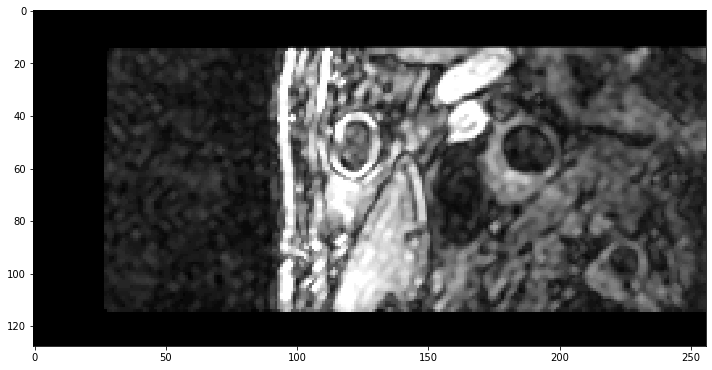

In [ ]:
random_index=366
fig = plt.figure(figsize=(10,30))
#ax1 = fig.add_subplot(1,2,1)
#ax1.imshow(Mask_auto_test_left[random_index][:,:,1],cmap=plt.cm.gray), ax1.set_title('mask auto')
imshow(X_test_3D_right[random_index],cmap=plt.cm.gray)


# Model



### Model loading

In [11]:
!unzip  "/content/drive/MyDrive/Challenge_VWS/Models.zip"

Archive:  /content/drive/MyDrive/Challenge_VWS/Models.zip
   creating: Models/
  inflating: Models/model_Unet_resnet34_Left.hdf5  
  inflating: Models/model_Unet_resnet34_Right.hdf5  


In [12]:
models_path = 'Models'
filename_model_left = 'model_Unet_resnet34_Left.hdf5'
filename_model_right = 'model_Unet_resnet34_Right.hdf5'

model_dir_l = os.path.join(path,models_path,filename_model_left)
model_l= load_model(model_dir_l, compile=False)

model_dir_r = os.path.join(path,models_path,filename_model_right)
model_r = load_model(model_dir_r, compile=False)

### Model prediction

In [ ]:
# Calcolo maschere automatiche per test left
x,y,z,k=X_test_3D_left.shape
Mask_auto_test_left=np.zeros((x,y,z,k),dtype=np.uint8)

cont_slice=0
for s in tqdm(X_test_3D_left):
    img1 = np.reshape(s,(1,128,256,3))
    softmax = model_l.predict(img1)
    
    
    mask_auto = softmax
    mask_auto[mask_auto<0.5] = 0
    mask_auto[mask_auto>=0.5] = 1

    # Save mask auto
    Mask_auto_test_left[cont_slice] = mask_auto
    cont_slice+=1

# Calcolo maschere automatiche per test right
x,y,z,k=X_test_3D_right.shape
Mask_auto_test_right=np.zeros((x,y,z,k),dtype=np.uint8)

cont_slice=0
for s in tqdm(X_test_3D_right):
   img1 = np.reshape(s,(1,128,256,3))
   softmax = model_r.predict(img1)
   
   
   mask_auto = softmax
   mask_auto[mask_auto<0.5] = 0
   mask_auto[mask_auto>=0.5] = 1

   # Save mask auto
   Mask_auto_test_right[cont_slice] = mask_auto
   cont_slice+=1



In [ ]:
Mask_auto_test_left_backup = np.copy(Mask_auto_test_left)
Mask_auto_test_right_backup = np.copy(Mask_auto_test_right)

# Post Processing

In [ ]:
#LEFT
Mask_auto_test_new=np.zeros_like(Mask_auto_test_left,dtype=bool)
Mask_auto_test_new[Mask_auto_test_left==0]=False
Mask_auto_test_new[Mask_auto_test_left==1]=True


for n_slice in (range(len(Mask_auto_test_new[:,:,:,2]))):
  Mask_auto_test_new[n_slice,:,:,1]=morphology.remove_small_holes(Mask_auto_test_new[n_slice,:,:,1],area_threshold=100,connectivity=3)
  Mask_auto_test_new[n_slice,:,:,1]=morphology.remove_small_objects(Mask_auto_test_new[n_slice,:,:,1],min_size=40)
  Mask_auto_test_new[n_slice,:,:,2]=morphology.remove_small_holes(Mask_auto_test_new[n_slice,:,:,2],area_threshold=64)
  Mask_auto_test_new[n_slice,:,:,2]=morphology.remove_small_objects(Mask_auto_test_new[n_slice,:,:,2],min_size=40)


Mask_auto_test_left[Mask_auto_test_new==False]=0
Mask_auto_test_left[Mask_auto_test_new==True]=1
#RIGHT

Mask_auto_test_new=np.zeros_like(Mask_auto_test_right,dtype=bool)
Mask_auto_test_new[Mask_auto_test_right==0]=False
Mask_auto_test_new[Mask_auto_test_right==1]=True
strel_ero = morphology.square(1)
strel_dil = morphology.square(1)
strel_ero_2 = morphology.square(1)


for n_slice in (range(len(Mask_auto_test_new[:,:,:,2]))):
 Mask_auto_test_new[n_slice,:,:,1]=morphology.remove_small_holes(Mask_auto_test_new[n_slice,:,:,1],area_threshold=100,connectivity=3)
 Mask_auto_test_new[n_slice,:,:,1]=morphology.remove_small_objects(Mask_auto_test_new[n_slice,:,:,1],min_size=40)
 Mask_auto_test_new[n_slice,:,:,2]=morphology.remove_small_holes(Mask_auto_test_new[n_slice,:,:,2],area_threshold=64)
 Mask_auto_test_new[n_slice,:,:,2]=morphology.remove_small_objects(Mask_auto_test_new[n_slice,:,:,2],min_size=40)


Mask_auto_test_right[Mask_auto_test_new==False]=0
Mask_auto_test_right[Mask_auto_test_new==True]=1

4398


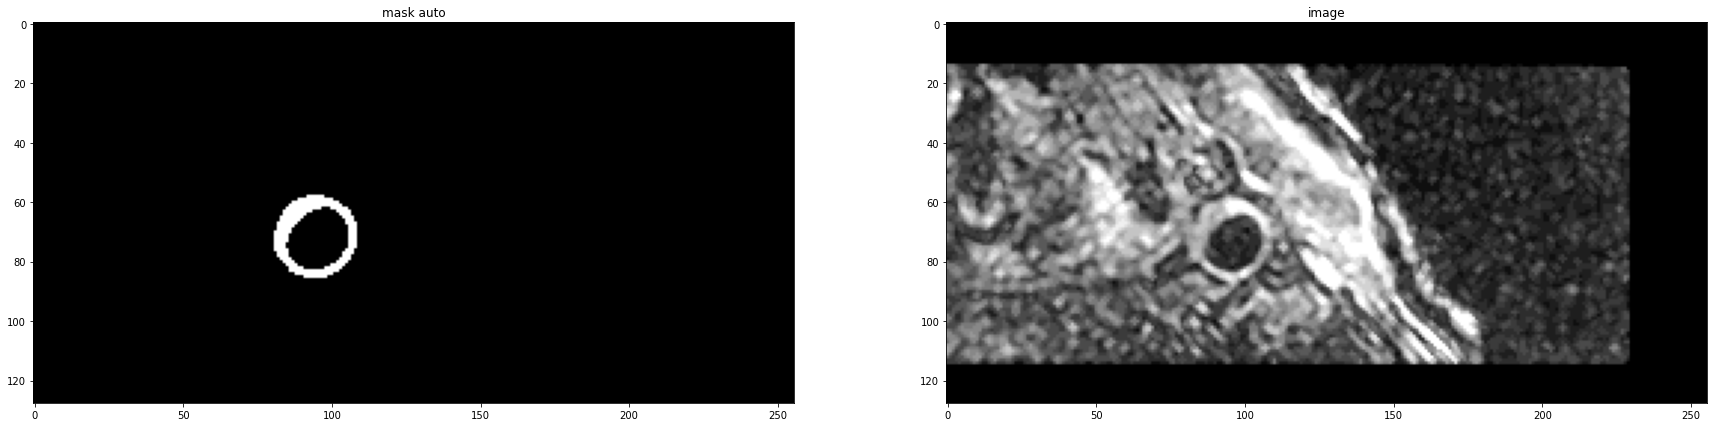

In [ ]:
# random_index = random.randint(0, len(Mask_auto_test_left))
random_index= 4398
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(Mask_auto_test_left[random_index][:,:,2],cmap=plt.cm.gray), ax1.set_title('mask auto')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(X_test_3D_left[random_index],cmap=plt.cm.gray), ax2.set_title('image')

print(random_index)


# Saving automatic masks

## Calcolo Centroidi di riferimento: Test

* Test Left

In [ ]:
# Calcolo centoidi per test left
cont_pz=0
cont_slice_pz=0
cont_slice_contour=0 #serviva per non far prendere la prima ma la seconda slice con due segmentazioni per
flag=False
centroidi_test_left=np.zeros((10,6),dtype=np.int16)
for slice_, n_slice , name in zip(Mask_auto_test_left[:,:,:,1],range(len(Mask_auto_test_left[:,:,:,1])),listOfimg_test):
  if(cont_pz<10 and cont_slice_pz<720-1):
    cont_slice_pz+=1
    avail_slice_pre=name.split('I')[1]
    avail_slice=int(avail_slice_pre.split('.')[0])
    if avail_slice<400:
      contours,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      if len(contours)==2 and flag==False:
          M_1 = cv2.moments(contours[0])
          M_2 = cv2.moments(contours[1])
          if M_1['m10']!=0 and M_1['m00']!=0 and M_1['m01']!=0 and M_2['m10']!=0 and M_2['m00']!=0 and M_2['m01']!=0:
            cx_1 = int(M_1['m10']/M_1['m00'])
            cy_1 = int(M_1['m01']/M_1['m00']) 
            cx_2 = int(M_2['m10']/M_2['m00'])
            cy_2 = int(M_2['m01']/M_2['m00'])
            cont_slice_contour+=1
            if cy_1!=cy_2: #and cont_slice_contour==2:
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(y==np.amin(y))
              ind_i=np.where(y==np.amax(y))
              centroidi_test_left[cont_pz][0]=x[ind_e[0]]
              centroidi_test_left[cont_pz][1]=y[ind_e[0]]
              centroidi_test_left[cont_pz][2]=x[ind_i[0]]
              centroidi_test_left[cont_pz][3]=y[ind_i[0]]
              centroidi_test_left[cont_pz][4]=cont_slice_pz
              centroidi_test_left[cont_pz][5]=cont_pz
              flag=True
            elif cy_1==cy_2 : 
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(x==np.amin(x))
              ind_i=np.where(x==np.amax(x))
              centroidi_test_left[cont_pz][0]=x[ind_e[0]]
              centroidi_test_left[cont_pz][1]=y[ind_e[0]]
              centroidi_test_left[cont_pz][2]=x[ind_i[0]]
              centroidi_test_left[cont_pz][3]=y[ind_i[0]]
              centroidi_test_left[cont_pz][4]=cont_slice_pz
              centroidi_test_left[cont_pz][5]=cont_pz
              flag=True
  else:
      cont_pz+=1
      cont_slice_pz=0 
      flag=False


## Divisione maschere in ICA ed ECA

* Test Left

## Calcolo Centroidi di riferimento: Validation

* Validation Left

In [ ]:
Mask_wall_ICAL_test_left=np.zeros_like(Mask_auto_test_left[:,:,:,0]) 
Mask_wall_ECAL_test_left=np.zeros_like(Mask_auto_test_left[:,:,:,0]) 
Mask_lume_ICAL_test_left=np.zeros_like(Mask_auto_test_left[:,:,:,0]) 
Mask_lume_ECAL_test_left=np.zeros_like(Mask_auto_test_left[:,:,:,0]) 
cont_pz=0
cont=0
cont_slice_pz=0
cont_lume_ECAL=0
cont_lume_ICAL=0
cont_wall_ECAL=0
cont_wall_ICAL=0
strel_dil = morphology.square(2)

In [ ]:
for slice_, n_slice, name in zip(Mask_auto_test_left[:,:,:,1],range(len(Mask_auto_test_left[:,:,:,1])),listOfimg_test):
  flag_ECAL=False
  flag_ICAL=False
  avail_slice_pre=name.split('I')[1]
  avail_slice=int(avail_slice_pre.split('.')[0])
  if np.any(slice_): 
    if(cont_pz<10 and cont_slice_pz<720):
      cont_slice_pz+=1
      if centroidi_test_left[cont_pz][0]!=0 and avail_slice<400:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        M_1 = cv2.moments(contours_lume[0])
        try:
          cx_1 = int(M_1['m10']/M_1['m00'])
          cy_1 = int(M_1['m01']/M_1['m00'])
          
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)

          if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))==0:
            Mask_lume_ECAL_test_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]]))==0:
            Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
          #elif abs(cx_1-centroidi_test[cont_pz][0])<abs(cx_1-centroidi_test[cont_pz][2]):
            Mask_lume_ECAL_test_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
          #elif abs(cx_1-centroidi_test[cont_pz][0])>abs(cx_1-centroidi_test[cont_pz][2]):
            Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
              
          
          contours_wall,_= cv2.findContours(Mask_auto_test_left[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)

          if len(contours_wall)>1:
            wall_mask_1=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            if redrawed_mask_wall_0[cy_1][cx_1]==0:
              wall_mask_1= redrawed_mask_wall_0
            else:
              wall_mask_1= np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
              wall_mask_1=morphology.dilation(wall_mask_1,strel_dil)
            if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))==0:
              Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]]))==0:  
              Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
            #elif abs(cx_1-centroidi_test[cont_pz][0])<abs(cx_1-centroidi_test[cont_pz][2]):
              Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
            #elif abs(cx_1-centroidi_test[cont_pz][0])>abs(cx_1-centroidi_test[cont_pz][2]):
              Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1

          elif len(contours_wall)==1:
            if np.any(contours_wall):
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))==0:
                Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]]))==0:
                Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
              #elif abs(cx_1-centroidi_test[cont_pz][0])<abs(cx_1-centroidi_test[cont_pz][2]):
                Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
              #elif abs(cx_1-centroidi_test[cont_pz][0])>abs(cx_1-centroidi_test[cont_pz][2]):
                Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1

          if len(contours_lume)>1 and len(contours_wall)>=2: 
            if len(contours_lume)==3:
              redrawed_mask_lume_1=np.zeros_like(slice_)
              redrawed_mask_lume_2=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              cv2.drawContours(redrawed_mask_lume_2,[contours_lume[2]],-1,255,-1)
              if np.sum(redrawed_mask_lume_2)>np.sum(redrawed_mask_lume_1):
                redrawed_mask_lume_1=redrawed_mask_lume_2
                M_2 = cv2.moments(contours_lume[2])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
              else:
                M_2 = cv2.moments(contours_lume[1])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
                redrawed_mask_lume_1=np.zeros_like(slice_)
                cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
            elif len(contours_lume)==2:
              M_2 = cv2.moments(contours_lume[1])
              cx_2 = int(M_2['m10']/M_2['m00'])
              cy_2 = int(M_2['m01']/M_2['m00'])
              redrawed_mask_lume_1=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              if n_slice==32:
                  print('eccolo') 
            
            wall_mask_2=np.zeros_like(slice_)
          
            if len(contours_wall)==2:
              if redrawed_mask_wall_1[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_1
            redrawed_mask_wall_2=np.zeros_like(slice_)
            redrawed_mask_wall_3=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_2,[contours_wall[2]],-1,255,-1)
            if len(contours_wall)==3:
              if redrawed_mask_wall_2[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_2
              else:
                wall_mask_2= np.logical_xor(redrawed_mask_wall_1,redrawed_mask_wall_2)
                wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            if len(contours_wall)==4:  
              cv2.drawContours(redrawed_mask_wall_3,[contours_wall[3]],-1,255,-1)
              wall_mask_2= np.logical_xor(redrawed_mask_wall_2,redrawed_mask_wall_3)
              wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            
            if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))==0:
              Mask_lume_ECAL_test_left[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_2
              cont_lume_ECAL+=1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]]))==0:
              Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_2
              cont_lume_ICAL+=1
              cont_wall_ICAL+=1
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
            #elif abs(cx_2-centroidi_test[cont_pz][0])<abs(cx_2-centroidi_test[cont_pz][2]):
             if flag_ECAL==False:   
                cont+=1
                Mask_lume_ECAL_test_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_2
                cont_lume_ECAL+=1
                cont_wall_ECAL+=1
             else:
              if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]])):
                Mask_lume_ECAL_test_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_2
                Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_1
              elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]])):
                Mask_lume_ECAL_test_left[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_1
                Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_2

            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][1],centroidi_test_left[cont_pz][0]]))>np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
            #elif abs(cx_2-centroidi_test[cont_pz][0])>abs(cx_2-centroidi_test[cont_pz][2]):
              if flag_ICAL==False: 
                Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_2
                cont_lume_ICAL+=1
                cont_wall_ICAL+=1
              else:
                if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
                  Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_2
                  Mask_lume_ECAL_test_left[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_1
                elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_left[cont_pz][3],centroidi_test_left[cont_pz][2]])):
                  Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_1
                  Mask_lume_ECAL_test_left[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ECAL_test_left[n_slice,:,:]=wall_mask_2

        except:
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
          Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume
          cont_lume_ICAL+=1
          cont+=1
          contours_wall,_= cv2.findContours(Mask_auto_test_left[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          if len(contours_wall)>1:
            wall_mask_2=np.zeros_like(slice_)
            redrawed_mask_wall_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
            wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_2
            cont_wall_ICAL+=1
          else: 
            if np.any(contours_wall):
              wall_mask_1=np.zeros_like(slice_) 
              redrawed_mask_wall_0=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
      else:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        redrawed_mask_lume=np.zeros_like(slice_)
        cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
        Mask_lume_ICAL_test_left[n_slice,:,:]=redrawed_mask_lume
        cont_lume_ICAL+=1
        
        contours_wall,_= cv2.findContours(Mask_auto_test_left[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_wall)>1:
          wall_mask_2=np.zeros_like(slice_)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
          cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
          wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
          wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
          Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_2
          cont_wall_ICAL+=1
        else:
          if np.any(contours_wall):  
            wall_mask_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            wall_mask_1=redrawed_mask_wall_0
            Mask_wall_ICAL_test_left[n_slice,:,:]=wall_mask_1
            cont_wall_ICAL+=1
 
    else:
      cont_pz+=1
      cont_slice_pz=0 

## Calcolo Centroidi di riferimento: Test

* Test Right

In [ ]:
# Calcolo centoidi per test right
cont_pz=0
cont_slice_pz=0
cont_slice_contour=0 #serviva per non far prendere la prima ma la seconda slice con due segmentazioni per
flag=False
centroidi_test_right=np.zeros((10,6),dtype=np.int16)
for slice_, n_slice , name in zip(Mask_auto_test_right[:,:,:,1],range(len(Mask_auto_test_right[:,:,:,1])),listOfimg_test):
  if(cont_pz<10 and cont_slice_pz<720-1):
    cont_slice_pz+=1
    avail_slice_pre=name.split('I')[1]
    avail_slice=int(avail_slice_pre.split('.')[0])
    if avail_slice<400:
      contours,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      if len(contours)==2 and flag==False:
          M_1 = cv2.moments(contours[0])
          M_2 = cv2.moments(contours[1])
          if M_1['m10']!=0 and M_1['m00']!=0 and M_1['m01']!=0 and M_2['m10']!=0 and M_2['m00']!=0 and M_2['m01']!=0:
            cx_1 = int(M_1['m10']/M_1['m00'])
            cy_1 = int(M_1['m01']/M_1['m00']) 
            cx_2 = int(M_2['m10']/M_2['m00'])
            cy_2 = int(M_2['m01']/M_2['m00'])
            cont_slice_contour+=1
            if cy_1!=cy_2 : #and cont_slice_contour==2:
              cont+=1
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(y==np.amin(y))
              ind_i=np.where(y==np.amax(y))
              centroidi_test_right[cont_pz][0]=x[ind_e[0]]
              centroidi_test_right[cont_pz][1]=y[ind_e[0]]
              centroidi_test_right[cont_pz][2]=x[ind_i[0]]
              centroidi_test_right[cont_pz][3]=y[ind_i[0]]
              centroidi_test_right[cont_pz][4]=cont_slice_pz
              centroidi_test_right[cont_pz][5]=cont_pz
              flag=True
            elif cy_1==cy_2 : 
              x=np.array([cx_1,cx_2])
              y=np.array([cy_1,cy_2])
              ind_e=np.where(x==np.amin(x))
              ind_i=np.where(x==np.amax(x))
              centroidi_test_right[cont_pz][0]=x[ind_e[0]]
              centroidi_test_right[cont_pz][1]=y[ind_e[0]]
              centroidi_test_right[cont_pz][2]=x[ind_i[0]]
              centroidi_test_right[cont_pz][3]=y[ind_i[0]]
              centroidi_test_right[cont_pz][4]=cont_slice_pz
              centroidi_test_right[cont_pz][5]=cont_pz
              flag=True
            
  else:
      cont_pz+=1
      cont_slice_pz=0 
      flag=False

## Divisione maschere in ICA ed ECA

* Test Right

## Ricostruzione Maschere

In [ ]:
Mask_wall_ICAR_test_right=np.zeros_like(Mask_auto_test_right[:,:,:,0]) 
Mask_wall_ECAR_test_right=np.zeros_like(Mask_auto_test_right[:,:,:,0]) 
Mask_lume_ICAR_test_right=np.zeros_like(Mask_auto_test_right[:,:,:,0]) 
Mask_lume_ECAR_test_right=np.zeros_like(Mask_auto_test_right[:,:,:,0]) 
cont_pz=0
cont=0
cont_slice_pz=0
cont_lume_ECAL=0
cont_lume_ICAL=0
cont_wall_ECAL=0
cont_wall_ICAL=0
strel_dil = morphology.square(2)

In [ ]:
for slice_, n_slice, name in zip(Mask_auto_test_right[:,:,:,1],range(len(Mask_auto_test_right[:,:,:,1])), listOfimg_test):
  flag_ECAL=False
  flag_ICAL=False
  avail_slice_pre=name.split('I')[1]
  avail_slice=int(avail_slice_pre.split('.')[0])
  if np.any(slice_): 
    if(cont_pz<10 and cont_slice_pz<720):
      cont_slice_pz+=1
      if centroidi_test_right[cont_pz][0]!=0 and avail_slice<400:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        M_1 = cv2.moments(contours_lume[0])
        try:
          cx_1 = int(M_1['m10']/M_1['m00'])
          cy_1 = int(M_1['m01']/M_1['m00'])
          
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)

          if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))==0:
            Mask_lume_ECAR_test_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]]))==0:
            Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]])):
          #elif abs(cx_1-centroidi_test[cont_pz][0])<abs(cx_1-centroidi_test[cont_pz][2]):
            Mask_lume_ECAR_test_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ECAL+=1
            flag_ECAL=True
          
          elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]])):
          #elif abs(cx_1-centroidi_test[cont_pz][0])>abs(cx_1-centroidi_test[cont_pz][2]):
            Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume
            cont_lume_ICAL+=1
            flag_ICAL=True
              
          
          contours_wall,_= cv2.findContours(Mask_auto_test_right[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)

          if len(contours_wall)>1:
            wall_mask_1=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            if redrawed_mask_wall_0[cy_1][cx_1]==0:
              wall_mask_1= redrawed_mask_wall_0
            else:
              wall_mask_1= np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
              wall_mask_1=morphology.dilation(wall_mask_1,strel_dil)
            if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))==0:
              Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]]))==0:  
              Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]])):
            #elif abs(cx_1-centroidi_test[cont_pz][0])<abs(cx_1-centroidi_test[cont_pz][2]):
              Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_1
              cont_wall_ECAL+=1
            elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]])):
            #elif abs(cx_1-centroidi_test[cont_pz][0])>abs(cx_1-centroidi_test[cont_pz][2]):
              Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1

          elif len(contours_wall)==1:
            if np.any(contours_wall):
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              if np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))==0:
                Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]]))==0:
                Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]])):
              #elif abs(cx_1-centroidi_test[cont_pz][0])<abs(cx_1-centroidi_test[cont_pz][2]):
                Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_1
                cont_wall_ECAL+=1
              elif np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_lright[cont_pz][2]])):
              #elif abs(cx_1-centroidi_test[cont_pz][0])>abs(cx_1-centroidi_test[cont_pz][2]):
                Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_1
                cont_wall_ICAL+=1

          if len(contours_lume)>1 and len(contours_wall)>=2:
            if len(contours_lume)==3:
              redrawed_mask_lume_1=np.zeros_like(slice_)
              redrawed_mask_lume_2=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              cv2.drawContours(redrawed_mask_lume_2,[contours_lume[2]],-1,255,-1)
              if np.sum(redrawed_mask_lume_2)>np.sum(redrawed_mask_lume_1):
                redrawed_mask_lume_1=redrawed_mask_lume_2
                M_2 = cv2.moments(contours_lume[2])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
              else:
                M_2 = cv2.moments(contours_lume[1])
                cx_2 = int(M_2['m10']/M_2['m00'])
                cy_2 = int(M_2['m01']/M_2['m00'])
                redrawed_mask_lume_1=np.zeros_like(slice_)
                cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
            elif len(contours_lume)==2:
              M_2 = cv2.moments(contours_lume[1])
              cx_2 = int(M_2['m10']/M_2['m00'])
              cy_2 = int(M_2['m01']/M_2['m00'])
              redrawed_mask_lume_1=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_lume_1,[contours_lume[1]],-1,255,-1)
              
            
            wall_mask_2=np.zeros_like(slice_)
          
            if len(contours_wall)==2:
              if redrawed_mask_wall_1[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_1
            redrawed_mask_wall_2=np.zeros_like(slice_)
            redrawed_mask_wall_3=np.zeros_like(slice_)
            
            if len(contours_wall)==3:
              cv2.drawContours(redrawed_mask_wall_2,[contours_wall[2]],-1,255,-1)
              if redrawed_mask_wall_2[cy_2][cx_2]==0:
                wall_mask_2= redrawed_mask_wall_2
              else:
                wall_mask_2= np.logical_xor(redrawed_mask_wall_1,redrawed_mask_wall_2)
                wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            if len(contours_wall)==4:  
              cv2.drawContours(redrawed_mask_wall_2,[contours_wall[2]],-1,255,-1)
              cv2.drawContours(redrawed_mask_wall_3,[contours_wall[3]],-1,255,-1)
              wall_mask_2= np.logical_xor(redrawed_mask_wall_2,redrawed_mask_wall_3)
              wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            
            if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))==0:
              Mask_lume_ECAR_test_right[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_2
              cont_lume_ECAL+=1
              cont_wall_ECAL+=1
              if n_slice==163:
                  print('i')
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]]))==0:
              Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume_1
              Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_2
              cont_lume_ICAL+=1
              cont_wall_ICAL+=1
              if n_slice==163:
                  print('i_2')
            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]])):
            #elif abs(cx_2-centroidi_test[cont_pz][0])<abs(cx_2-centroidi_test[cont_pz][2]):
             if flag_ECAL==False:   
                cont+=1
                Mask_lume_ECAR_test_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_2
                cont_lume_ECAL+=1
                cont_wall_ECAL+=1
                
             else:
              if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]])):
                Mask_lume_ECAR_test_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_2
                Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_1
                
              elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]])):
                Mask_lume_ECAR_test_right[n_slice,:,:]=redrawed_mask_lume
                Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_1
                Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_2
                

            elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][1],centroidi_test_right[cont_pz][0]]))>np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]])):
            #elif abs(cx_2-centroidi_test[cont_pz][0])>abs(cx_2-centroidi_test[cont_pz][2]):
              if flag_ICAL==False: 
                Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume_1
                Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_2
                cont_lume_ICAL+=1
                cont_wall_ICAL+=1
                
              else:
                if np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]]))<np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]])):
                  Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_2
                  Mask_lume_ECAR_test_right[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_1
                  
                elif np.linalg.norm(np.array([cy_2,cx_2])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]]))>np.linalg.norm(np.array([cy_1,cx_1])-np.array([centroidi_test_right[cont_pz][3],centroidi_test_right[cont_pz][2]])):
                  Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume
                  Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_1
                  Mask_lume_ECAR_test_right[n_slice,:,:]=redrawed_mask_lume_1
                  Mask_wall_ECAR_test_right[n_slice,:,:]=wall_mask_2
                  

        except:
          redrawed_mask_lume=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
          Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume
          cont_lume_ICAL+=1
          cont+=1
          contours_wall,_= cv2.findContours(Mask_auto_test_right[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
          if len(contours_wall)>1:
            wall_mask_2=np.zeros_like(slice_)
            redrawed_mask_wall_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
            wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
            wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
            Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_2
            cont_wall_ICAL+=1
          else: 
            if np.any(contours_wall):
              wall_mask_1=np.zeros_like(slice_) 
              redrawed_mask_wall_0=np.zeros_like(slice_)
              cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
              wall_mask_1=redrawed_mask_wall_0
              Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_1
              cont_wall_ICAL+=1
      else:
        contours_lume,_= cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        redrawed_mask_lume=np.zeros_like(slice_)
        cv2.drawContours(redrawed_mask_lume,[contours_lume[0]],-1,255,-1)
        Mask_lume_ICAR_test_right[n_slice,:,:]=redrawed_mask_lume
        cont_lume_ICAL+=1
        
        contours_wall,_= cv2.findContours(Mask_auto_test_right[n_slice,:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_wall)>1:
          wall_mask_2=np.zeros_like(slice_)
          redrawed_mask_wall_0=np.zeros_like(slice_)
          redrawed_mask_wall_1=np.zeros_like(slice_)
          cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
          cv2.drawContours(redrawed_mask_wall_1,[contours_wall[1]],-1,255,-1)
          wall_mask_2=np.logical_xor(redrawed_mask_wall_0,redrawed_mask_wall_1)
          wall_mask_2=morphology.dilation(wall_mask_2,strel_dil)
          Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_2
          cont_wall_ICAL+=1
        else:
          if np.any(contours_wall):  
            wall_mask_1=np.zeros_like(slice_)
            redrawed_mask_wall_0=np.zeros_like(slice_)
            cv2.drawContours(redrawed_mask_wall_0,[contours_wall[0]],-1,255,-1)
            wall_mask_1=redrawed_mask_wall_0
            Mask_wall_ICAR_test_right[n_slice,:,:]=wall_mask_1
            cont_wall_ICAL+=1
        
    else:
      cont_pz+=1
      cont_slice_pz=0 


## Ricostruzione Maschere

In [ ]:
mask_empty=np.zeros_like(Mask_lume_ICAR_test_right[0,:,:],dtype=np.uint8)
final_mask=np.zeros((100,720),dtype=np.uint8)
lateral=np.zeros((128,104),dtype=np.uint8)

cont_pz=0

for slice_, n_slice , name_r in zip(Mask_lume_ICAR_test_right,range(len(Mask_lume_ICAR_test_right)),listOfimg_test):
  pi = int(listOfPz_test[cont_pz].split('_')[1].split('P')[1])
  pi_name=int(name_r.split('EP')[1].split('S')[0])
  if pi_name==pi:
    if np.any(slice_):
      mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
      final_mask=mask_complete[14:114,:]
      name=name_r.split('.')[0]
      final_mask[final_mask==1]=255
      if cont_pz in list_pz_ToResize:
        # se le dimensioni non sono 100x720, le riporto alle dimensioni originali (160x640)
        final_mask = skimage.transform.resize(final_mask, (160,640), anti_aliasing=True) 
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ICAR'+'_'+'lume'+'.png'),final_mask)
      else:
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ICAR'+'_'+'lume'+'.png'),final_mask)
  else:
    cont_pz+=1

cont_pz=0

for slice_, n_slice , name_r in zip(Mask_lume_ECAR_test_right,range(len(Mask_lume_ECAR_test_right)),listOfimg_test): 
  pi = int(listOfPz_test[cont_pz].split('_')[1].split('P')[1])
  pi_name=int(name_r.split('EP')[1].split('S')[0])
  if pi_name==pi:
    if np.any(slice_):
      mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
      final_mask=mask_complete[14:114,:]
      name=name_r.split('.')[0]
      final_mask[final_mask==1]=255
      if cont_pz in list_pz_ToResize:
        final_mask = skimage.transform.resize(final_mask, (160,640), anti_aliasing=True) 
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ECAR'+'_'+'lume'+'.png'),final_mask)
      else:
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ECAR'+'_'+'lume'+'.png'),final_mask)
  else:
    cont_pz+=1

cont_pz=0

for slice_, n_slice , name_l in zip(Mask_lume_ICAL_test_left,range(len(Mask_lume_ICAL_test_left)),listOfimg_test): 
  pi = int(listOfPz_test[cont_pz].split('_')[1].split('P')[1])
  pi_name=int(name_l.split('EP')[1].split('S')[0])
  if pi_name==pi:
    if np.any(slice_):
      mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
      final_mask=mask_complete[14:114,:]
      name=name_l.split('.')[0]
      final_mask[final_mask==1]=255
      if cont_pz in list_pz_ToResize:
        final_mask = skimage.transform.resize(final_mask, (160,640), anti_aliasing=True) 
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ICAL'+'_'+'lume'+'.png'),final_mask)
      else:
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ICAL'+'_'+'lume'+'.png'),final_mask)
  else:
    cont_pz+=1

cont_pz=0

for slice_, n_slice , name_l in zip(Mask_lume_ECAL_test_left,range(len(Mask_lume_ECAL_test_left)),listOfimg_test):
  pi = int(listOfPz_test[cont_pz].split('_')[1].split('P')[1])
  pi_name=int(name_l.split('EP')[1].split('S')[0])
  if pi_name==pi:
    if np.any(slice_):
      mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
      final_mask=mask_complete[14:114,:]
      name=name_l.split('.')[0]
      final_mask[final_mask==1]=255
      if cont_pz in list_pz_ToResize:
        final_mask = skimage.transform.resize(final_mask, (160,640), anti_aliasing=True) 
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ECAL'+'_'+'lume'+'.png'),final_mask)
      else:
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ECAL'+'_'+'lume'+'.png'),final_mask)
  else:
    cont_pz+=1

In [ ]:
cont_pz=0

for slice_, n_slice , name_r in zip(Mask_wall_ICAR_test_right,range(len(Mask_wall_ICAR_test_right)),listOfimg_test):
  pi = int(listOfPz_test[cont_pz].split('_')[1].split('P')[1])
  pi_name=int(name_r.split('EP')[1].split('S')[0])
  if pi_name==pi:
    if np.any(slice_):
      mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
      final_mask=mask_complete[14:114,:]
      name=name_r.split('.')[0]
      final_mask[final_mask==1]=255
      if cont_pz in list_pz_ToResize:
        final_mask = skimage.transform.resize(final_mask, (160,640), anti_aliasing=True) 
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ICAR'+'_'+'wall'+'.png'),final_mask)
      else:
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ICAR'+'_'+'wall'+'.png'),final_mask)
  else:
    cont_pz+=1

cont_pz=0

for slice_, n_slice , name_r in zip(Mask_wall_ECAR_test_right,range(len(Mask_wall_ECAR_test_right)),listOfimg_test):
  pi = int(listOfPz_test[cont_pz].split('_')[1].split('P')[1])
  pi_name=int(name_r.split('EP')[1].split('S')[0])
  if pi_name==pi:
    if np.any(slice_):
      mask_complete=np.concatenate((lateral,slice_,mask_empty,lateral),axis=1)
      final_mask=mask_complete[14:114,:]
      name=name_r.split('.')[0]
      final_mask[final_mask==1]=255
      if cont_pz in list_pz_ToResize:
        final_mask = skimage.transform.resize(final_mask, (160,640), anti_aliasing=True) 
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ECAR'+'_'+'wall'+'.png'),final_mask)
      else:
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ECAR'+'_'+'wall'+'.png'),final_mask)
  else:
    cont_pz+=1

cont_pz=0

for slice_, n_slice , name_l in zip(Mask_wall_ICAL_test_left,range(len(Mask_wall_ICAL_test_left)),listOfimg_test):
  pi = int(listOfPz_test[cont_pz].split('_')[1].split('P')[1])
  pi_name=int(name_l.split('EP')[1].split('S')[0])
  if pi_name==pi:
    if np.any(slice_):
      mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
      final_mask=mask_complete[14:114,:]
      name=name_l.split('.')[0]
      final_mask[final_mask==1]=255
      if cont_pz in list_pz_ToResize:
        final_mask = skimage.transform.resize(final_mask, (160,640), anti_aliasing=True) 
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ICAL'+'_'+'wall'+'.png'),final_mask)
      else:
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ICAL'+'_'+'wall'+'.png'),final_mask)
  else:
    cont_pz+=1

cont_pz=0

for slice_, n_slice , name_l in zip(Mask_wall_ECAL_test_left,range(len(Mask_wall_ECAL_test_left)),listOfimg_test): 
  pi = int(listOfPz_test[cont_pz].split('_')[1].split('P')[1])
  pi_name=int(name_l.split('EP')[1].split('S')[0])
  if pi_name==pi:
    if np.any(slice_):
      mask_complete=np.concatenate((lateral,mask_empty,slice_,lateral),axis=1)
      final_mask=mask_complete[14:114,:]
      name=name_l.split('.')[0]
      final_mask[final_mask==1]=255
      if cont_pz in list_pz_ToResize:
        final_mask = skimage.transform.resize(final_mask, (160,640), anti_aliasing=True) 
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ECAL'+'_'+'wall'+'.png'),final_mask)
      else:
        imsave(os.path.join(newTest_dir,listOfPz_test[cont_pz],name +'_ECAL'+'_'+'wall'+'.png'),final_mask)
  else:
    cont_pz+=1